## Progress since last meeting:

### - Load .jp2 files in yt
### - Add multiple bands in field list
### - Sample code for up/down sampling in Rasterio
### - Sample code for reprojecting in Rasterio

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from rasterio.windows import Window
from shapely.geometry import box
from pathlib import Path
import numpy as np
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
import time

# yt packages
import yt
import yt.extensions.geotiff

# CPU usage
import psutil

# package of resampling methods
from rasterio.enums import Resampling

from rasterio.warp import calculate_default_transform, reproject, Resampling


## Load *.jp2 format and add field bands

In [2]:
s2_file = ('C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B02_20m.jp2')

In [3]:
ds = yt.load(s2_file)

yt : [INFO     ] 2021-03-05 11:56:03,609 Parameters: domain_dimensions         = [5490 5490    1]
yt : [INFO     ] 2021-03-05 11:56:03,613 Parameters: domain_left_edge          = [ 399960. 6090240.       0.] m
yt : [INFO     ] 2021-03-05 11:56:03,615 Parameters: domain_right_edge         = [5.09760e+05 6.20004e+06 1.00000e+00] m


In [8]:
ds.field_list

[('bands', 'AOT'),
 ('bands', 'B02'),
 ('bands', 'B03'),
 ('bands', 'B04'),
 ('bands', 'B05'),
 ('bands', 'B06'),
 ('bands', 'B07'),
 ('bands', 'B11'),
 ('bands', 'B12'),
 ('bands', 'B8A'),
 ('bands', 'SCL'),
 ('bands', 'TCI'),
 ('bands', 'WVP')]

In [9]:
ds._field_filename

{'AOT': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_AOT_20m.jp2',
 'B02': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B02_20m.jp2',
 'B03': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B03_20m.jp2',
 'B04': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B04_20m.jp2',
 'B05': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B05_20m.jp2',
 'B06': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B06_20m.jp2',
 'B07': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B07_20m.jp2',
 'B11': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B11_20m.jp2',
 'B12': 'C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/s2_sample/T30UVG_20200601T113331_B12_20m.jp2',
 'B8A': 'C:/Users/arevi/OneDrive/YT_G

In [4]:
# Define dimensions
width = ds.arr(2000, 'm')
height = ds.arr(2000,'m') 
rectangle_centre = ds.arr([487309,6196162],'m')

rectangular_yt_container = ds.rectangle_from_center(rectangle_centre,width,height)

In [ ]:
rectangular_yt_container[('bands','B06')]

yt : [INFO     ] 2021-03-05 22:34:49,749 xlim = 486309.000000 488309.000000
yt : [INFO     ] 2021-03-05 22:34:49,752 ylim = 6195162.000000 6197162.000000
yt : [INFO     ] 2021-03-05 22:34:49,755 xlim = 486309.000000 488309.000000
yt : [INFO     ] 2021-03-05 22:34:49,757 ylim = 6195162.000000 6197162.000000
yt : [INFO     ] 2021-03-05 22:34:49,762 Making a fixed resolution buffer of (('bands', 'TCI')) 800 by 800



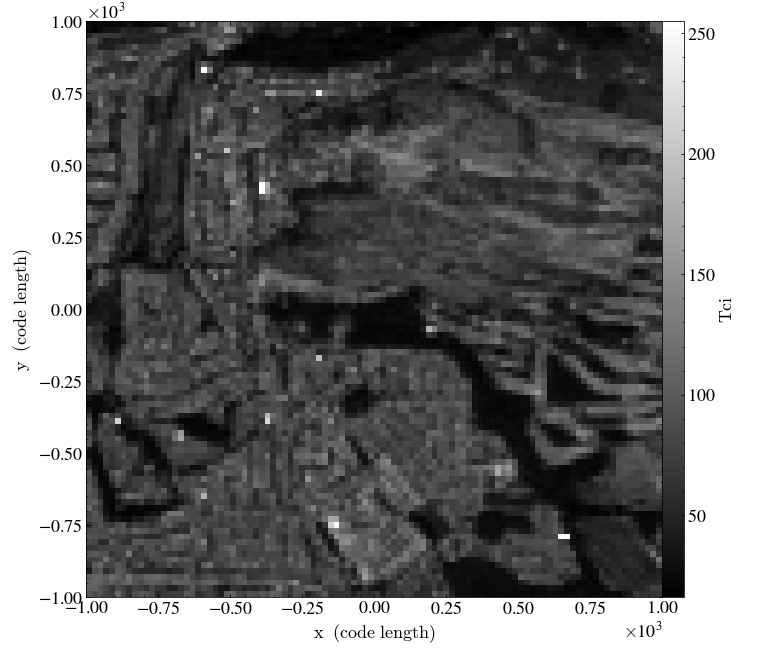

In [11]:
p = ds.plot(('bands', 'TCI'), height=height, width=width, center=rectangle_centre)
p.set_log(('bands', 'TCI'), False)
p.set_cmap(('bands', 'TCI'), 'B-W LINEAR')
p.show()

## Rasterio image up/down sampling

In [ ]:
s2_file = ('C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/test_resampling_v2.tif')

In [ ]:
with rasterio.open(s2_file) as dataset:
    original_image = dataset.read()

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
ax1.imshow(original_image[1,:,:], 'RdYlGn', interpolation='none')

In [ ]:
upscale_factor = 0.5

In [ ]:
with rasterio.open(s2_file) as dataset:

    # resample data to target shape
    resampled = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / resampled.shape[-1]),
        (dataset.height / resampled.shape[-2])
    )

In [ ]:
original_image.shape

In [ ]:
resampled.shape

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
ax1.imshow(resampled[1,:,:], 'RdYlGn', interpolation='none')

## Rasterio reprojecting image

In [ ]:
# destination geographical coordinate system
dst_crs = 'EPSG:4326'

In [ ]:
with rasterio.open(s2_file) as dataset:
    original_image = dataset.read(1)
    print(dataset.crs)

In [ ]:
with rasterio.open(s2_file) as src:
    print(src.shape)
    print(src.dtypes)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    reproject_array = np.zeros((224,472),dtypes=np.uint8)
    
    with rasterio.open('C:/Users/arevi/OneDrive/YT_GITHUB_v2/TEST_DATASETS/test_crs.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
        print(dst.shape)

In [ ]:
np.zeros((224,472))